## Data Summary

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import requests
import seaborn as sns
import missingno
from datetime import datetime, timedelta
import os
from os import walk
from shapely.geometry import LineString, mapping
from itertools import combinations
import re
import folium
import fiona
import pyarrow
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats

<a id="intro"></a>

## Contents

[Functions](#functions)<br>
[Core data features](#features)<br>
[Location and time based features](#loctime)<br>

#### Functions <a id="functions" ></a>

[Back to contents](#intro)

In [2]:
# import extra data
nyc_gdf = gpd.read_file("./shp/taxi_zones.shp")
look_up = pd.read_csv("taxi+_zone_lookup.csv")

# defining some functions
def clean_yellow_taxi_data(df):
    """Given a yellow taxi df applies the transformations described in Data exploration and cleaning notebook"""
    # drop duplicates
    df = df.drop_duplicates()
    
    # $1.25 for trips from LaGuardia and JFK airports
    df.loc[df["PULocationID"].
                        isin(nyc_gdf[nyc_gdf["zone"].isin(["LaGuardia Airport", "JFK Airport"])].loc[:, "LocationID"].to_list()), "airport_fee"] = 1.25
    
    # negative fares, tips, tolls, and total amount to positive
    df.loc[:, "fare_amount"] = abs(df["fare_amount"])
    df.loc[:, "tip_amount"] = abs(df["tip_amount"])
    df.loc[:, "tolls_amount"] = abs(df["tolls_amount"])
    df.loc[:, "total_amount"] = abs(df["total_amount"])
    
    # drop trips with more than 9 passengers
    df = df.drop(df[df.passenger_count > 9].index)
    
    # non-zero values of MTA_tax and Improvement_surcharge to 0.5 and 0.3 respectivelly
    df.loc[df["mta_tax"] != 0, "mta_tax"] = 0.5
    df.loc[df["improvement_surcharge"] != 0, "improvement_surcharge"] = 0.3
    
    # drop super expensive-short and super cheap-long trips
    df = df.drop(df[df.trip_distance > 4000].index)
    df = df.drop(df[df.total_amount > 100000].index)
    
    # voided trips
    df.loc[df[(df.trip_distance == 0) & (df.total_amount == 0)].index, "payment_type"] = 6
    
    # drop errors
    df = df.drop(df[(df.trip_distance == 0) & (df.payment_type != 6)].index)
    df = df.drop(df[(df.total_amount == 0) & (df.payment_type != 6)].index)
    
    # Let's create some new variables
    df["travel_time"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["travel_time_hour"] = df['travel_time'] / np.timedelta64(1, 'h')
    df["avg_speed"] = df["trip_distance"] / df["travel_time_hour"]
    df["dollar_per_mile"] = df["total_amount"] / df["trip_distance"]
    
    # drop errors
    df = df.drop(df[df.travel_time_hour <= 0].index)
    df = df.drop(df[df.travel_time_hour > 200].index)
    df = df.drop(df[df.avg_speed >= 93].index)
    
    # drop ratecode id > 6
    df = df.drop(df[df.RatecodeID > 6].index)
    
    # rate code ID
    df.loc[(df['RatecodeID'] != 3) & ((df['PULocationID'] == 1) | ((df['DOLocationID'] == 1))), "RatecodeID"] = 3
    df.loc[(df['RatecodeID'] != 4) & ((df['PULocationID'] == 250) | ((df['DOLocationID'] == 250))), "RatecodeID"] = 4
    df.loc[(df['RatecodeID'] != 2) & ((df['PULocationID'] == 132) | ((df['DOLocationID'] == 132))), "RatecodeID"] = 2
    
    return df
    

def get_cleaned_data(month_request, year):
    """Given a list of months and a year, check if the data is dowloaded or download it in order to create the df"""
    dates = [datetime(day= 1, month = month_request[month], year = year) for month in range(0,3)]
    
    taxi_trips = pd.DataFrame()
    for month in dates:
        date = str(month.year) + str("-") + str('{:02d}'.format(month.month))
        
        try:
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        except:
            url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + date + ".parquet"
            response = requests.get(url, allow_redirects=True)
            open("./data/yellow_tripdata_" + date + ".parquet", "wb").write(response.content)
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        taxi_trips = pd.concat([taxi_trips, monthly_trips])
            
    taxi_trips = clean_yellow_taxi_data(taxi_trips)
        
    return taxi_trips
    

def scatterplot(df, var1, var2):
    """Given two variables of a df makes a scatter plot"""
    data = pd.concat([df[var1], df[var2]], axis=1)
    data.plot.scatter(x=var1 , y=var2)

In [3]:
month_request = [3, 6, 11]
year = 2017
taxi_trips_2017 = get_cleaned_data(month_request, year)

C:\Users\berta\AppData\Local\Temp\ipykernel_20232\1805238688.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "fare_amount"] = abs(df["fare_amount"])
C:\Users\berta\AppData\Local\Temp\ipykernel_20232\1805238688.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "tip_amount"] = abs(df["tip_amount"])
C:\Users\berta\AppData\Local\Temp\ipykernel_20232\1805238688.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

#### Core data features <a id="features" ></a>

[Back to contents](#intro)

First of all, let's analyze the most valuable variable of our dataset: tip amount. In the cleaning function super expensive trips were drop off but for now we don't know if it was enough

In [4]:
taxi_trips_2017.tip_amount.describe()

count    2.860281e+07
mean     1.867152e+00
std      2.566015e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.360000e+00
75%      2.460000e+00
max      4.500000e+02
Name: tip_amount, dtype: float64

Text(0.5, 1.0, 'Tip amount distribution between 0 and 100')

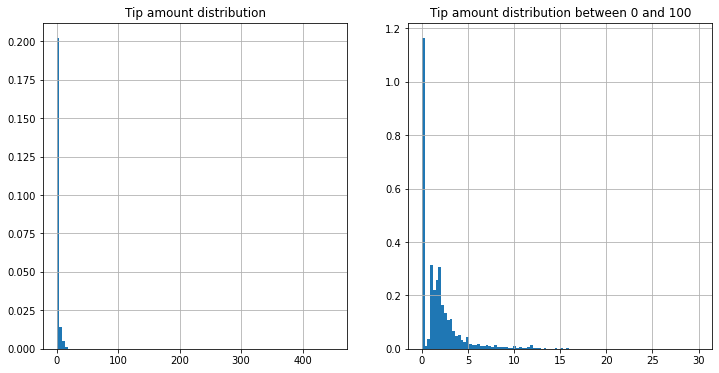

In [6]:
plt.subplot(1,2,1)
taxi_trips_2017.tip_amount.hist(bins=100, figsize=(12,6), density=True)
plt.title('Tip amount distribution')
plt.subplot(1,2,2)
taxi_trips_2017.tip_amount.hist(bins=100, figsize=(12,6), range=[0, 30], density=True)
plt.title('Tip amount distribution between 0 and 100')

Analysing the distribution of total amount there are some points to take into account:

    1. Most observations are 0, however there are super expensive trips... Max is higher than 400...
    2. Tip amount is deviated from the normal distibution
    3. Tip amount have appreciable possitive skewness and show peakedness

In [7]:
#skewness and kurtosis
print("Skewness: %f" % taxi_trips_2017['tip_amount'].skew())
print("Kurtosis: %f" % taxi_trips_2017['tip_amount'].kurt())

Skewness: 8.348488
Kurtosis: 584.925633


Let's explore the relationship between total amount and other numerical variables

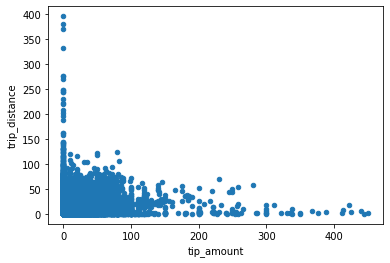

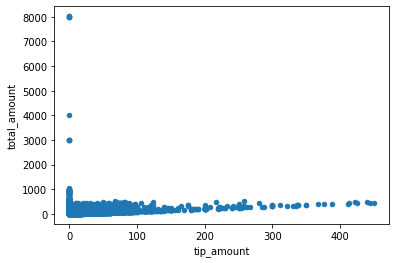

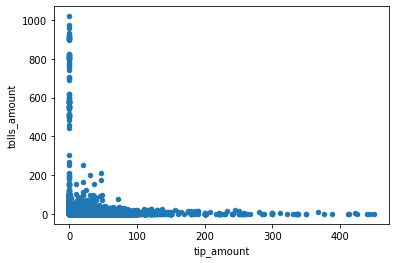

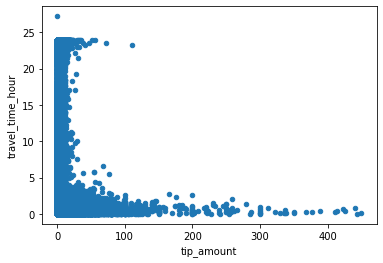

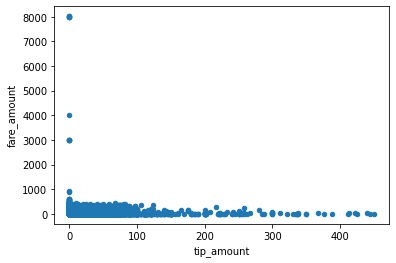

In [11]:
scatterplot(taxi_trips_2017, "tip_amount", "trip_distance")
scatterplot(taxi_trips_2017, "tip_amount", "total_amount")
scatterplot(taxi_trips_2017, "tip_amount", "tolls_amount")
scatterplot(taxi_trips_2017, "tip_amount", "travel_time_hour")
scatterplot(taxi_trips_2017, "tip_amount", "fare_amount")

And not numerical variables

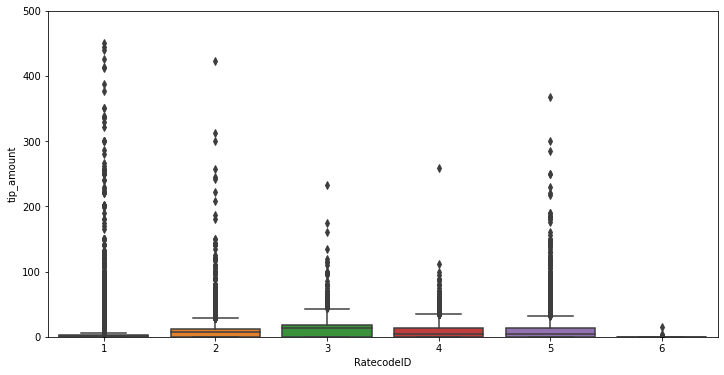

In [15]:
#box plot overallqual/saleprice
var = 'RatecodeID'
data = pd.concat([taxi_trips_2017['tip_amount'], taxi_trips_2017[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="tip_amount", data=data)
fig.axis(ymin=0, ymax=500);

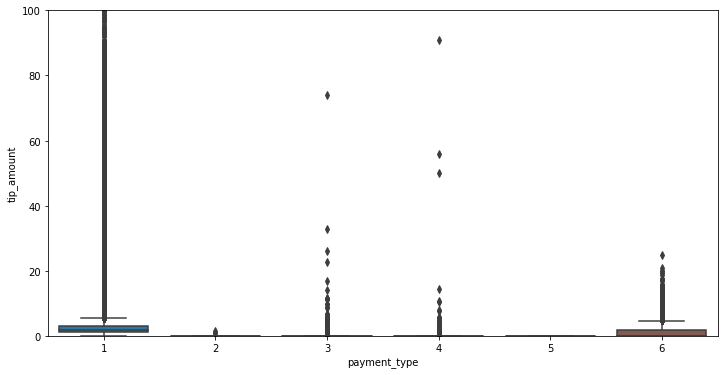

In [13]:
#box plot overallqual/saleprice
var = 'payment_type'
data = pd.concat([taxi_trips_2017['tip_amount'], taxi_trips_2017[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="tip_amount", data=data)
fig.axis(ymin=0, ymax=100);

In [14]:
#standardizing data
tipamount_scaled = StandardScaler().fit_transform(taxi_trips_2017['tip_amount'][:,np.newaxis]);
low_range = tipamount_scaled[tipamount_scaled[:,0].argsort()][:20]
high_range= tipamount_scaled[tipamount_scaled[:,0].argsort()][-20:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

C:\Users\berta\AppData\Local\Temp\ipykernel_20232\2175812188.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tipamount_scaled = StandardScaler().fit_transform(taxi_trips_2017['tip_amount'][:,np.newaxis]);


outer range (low) of the distribution:
[[-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]
 [-0.72764665]]

outer range (high) of the distribution:
[[120.86168446]
 [124.84451447]
 [127.87645356]
 [129.96139882]
 [130.33162274]
 [130.62780188]
 [130.82655367]
 [130.93177521]
 [135.67064145]
 [135.67064145]
 [142.56460064]
 [146.11095613]
 [150.47959844]
 [159.63776922]
 [160.37042288]
 [163.94795512]
 [165.08200946]
 [170.74448696]
 [172.30332454]
 [174.64158091]]


- The two super expensive values (some graphs above) seem strange and are not following the crowd... Maybe there are errors or maybe not but are not representative so we will define them as outliers. 
- According to the standarizedd data, there are some observations that are too far from 0 so can be not represeentative.
- Low values are near to 0, however there are many high values wich are out of range, so it is crucial to be careful

In [16]:
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.total_amount > 3000].index)

<AxesSubplot:>

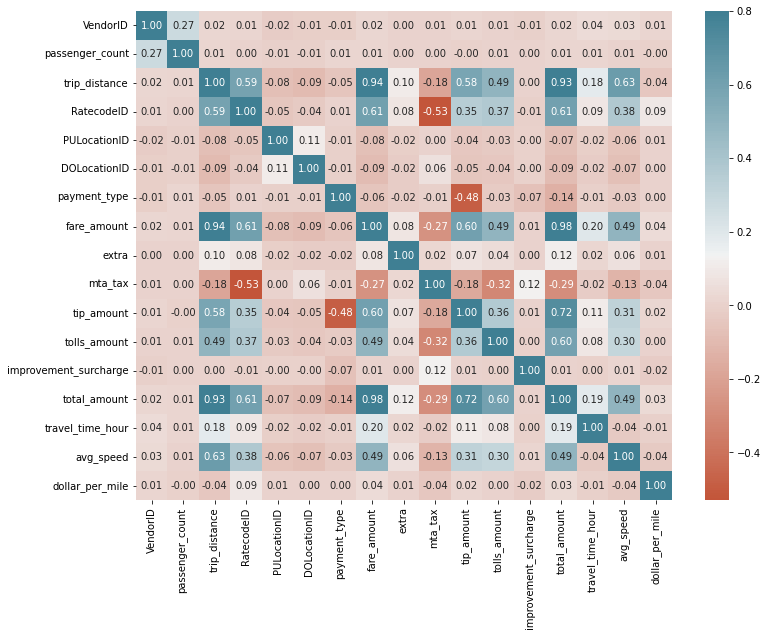

In [17]:
corrmat = taxi_trips_2017.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, cmap=sns.diverging_palette(20, 220, n=200), fmt='.2f', square=False, annot=True)

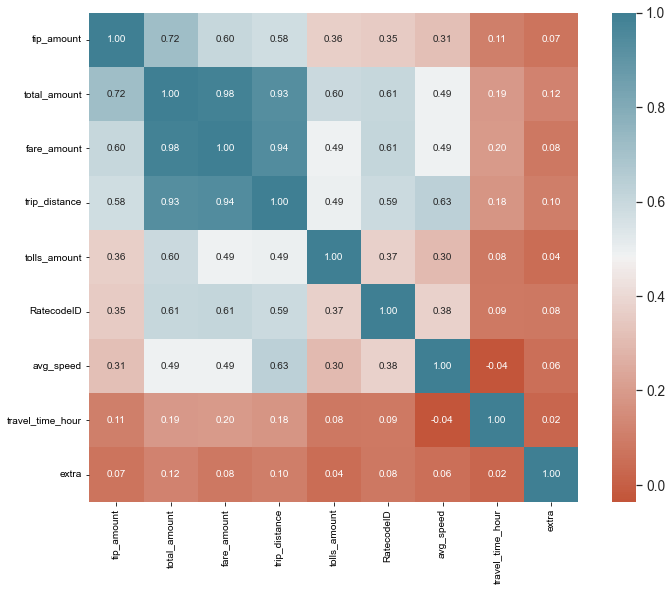

In [18]:
#total_amount correlation matrix
k = 9 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))
cols = corrmat.nlargest(k, 'tip_amount')['tip_amount'].index
cm = np.corrcoef(taxi_trips_2017[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values, cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

As we can expect, the most correlated variables to total_amount are fare and tip amount and trip distance... 

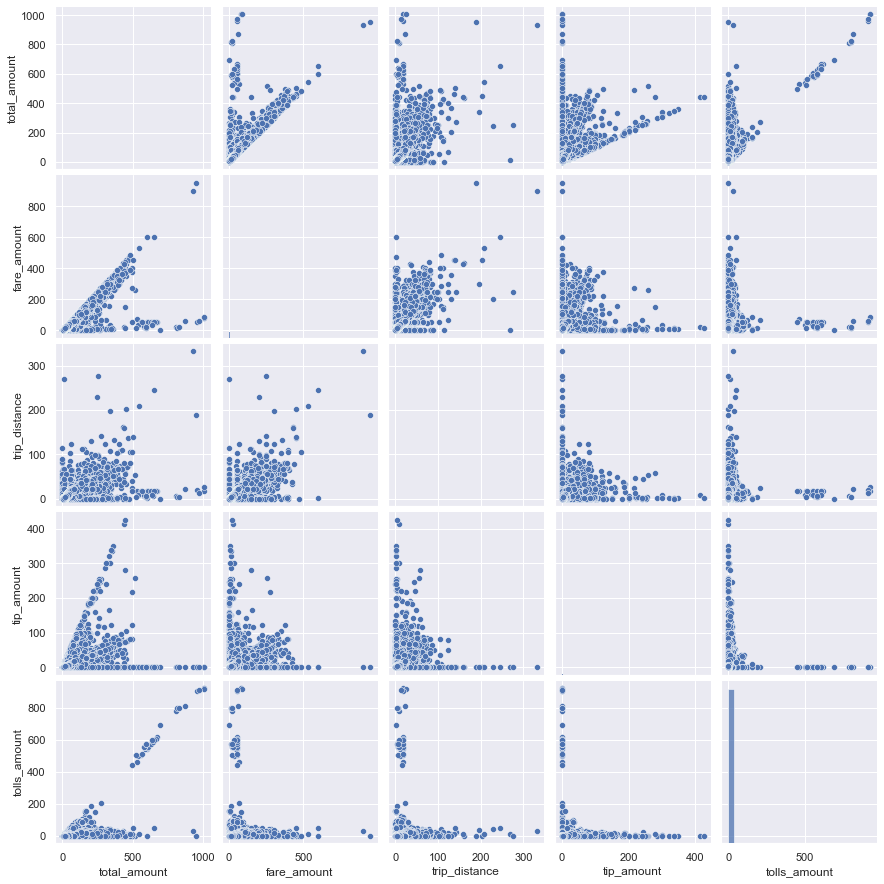

In [69]:
#scatterplot
sns.set()
cols = ['total_amount', 'fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount']
sns.pairplot(taxi_trips_2017[cols], height = 2.5)
plt.show();

The pairplot shows some insights that must be taken into account:
    
    1. Tips amount depends on the passenger trip. There are many trips with no tips and super long trips without tips
    2. Tolls existance depends on the locations but is not strongly related to other variables
    3. Fare amount and trip distance seem to be slightly possitively correlated. 
    4. There are not strong correlateions among numerical variables of the dataset

#### Location and time based features <a id="features" ></a>

[Back to contents](#loctime)

<AxesSubplot:>

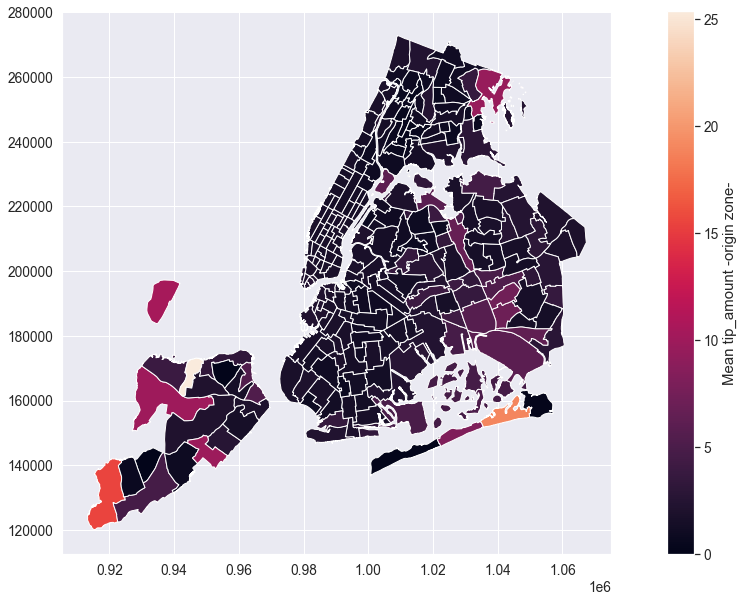

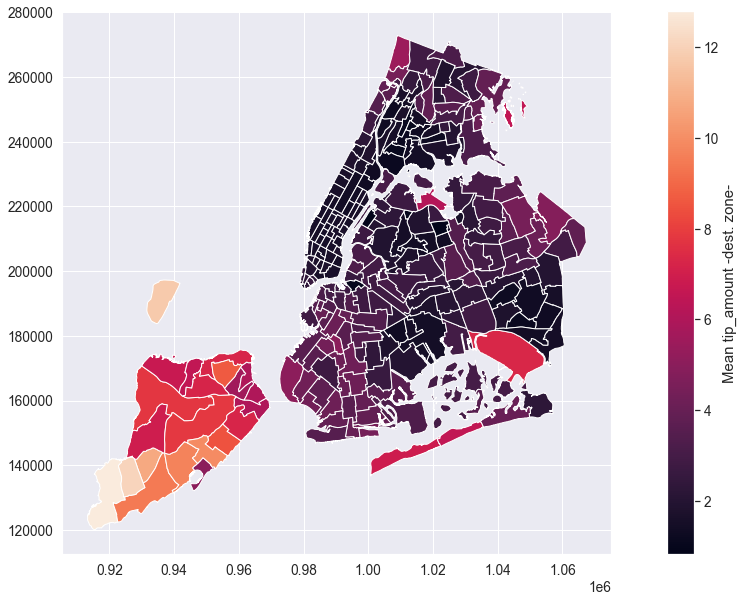

In [21]:
tip_amount_mean_origin = dict(zip(taxi_trips_2017.groupby("PULocationID").agg({"tip_amount": "mean"}).index,
                                taxi_trips_2017.groupby("PULocationID").agg({"tip_amount": "mean"})["tip_amount"]))
tip_amount_mean_destination = dict(zip(taxi_trips_2017.groupby("DOLocationID").agg({"tip_amount": "mean"}).index,
                                         taxi_trips_2017.groupby("DOLocationID").agg({"tip_amount": "mean"})["tip_amount"]))

nyc_gdf["tip_amount_mean_origin"] = nyc_gdf["LocationID"].map(tip_amount_mean_origin)
nyc_gdf["tip_amount_mean_destination"] = nyc_gdf["LocationID"].map(tip_amount_mean_destination)

nyc_gdf.plot(column = 'tip_amount_mean_origin',
             legend = True,
             figsize = [20,10],
             legend_kwds = {'label': "Mean tip_amount -origin zone-"})

nyc_gdf.plot(column = 'tip_amount_mean_destination',
             legend = True,
             figsize = [20,10],
             legend_kwds = {'label': "Mean tip_amount -dest. zone-"})

It is seems that the borough incluence the tip amount...

<AxesSubplot:xlabel='tpep_pickup_datetime'>

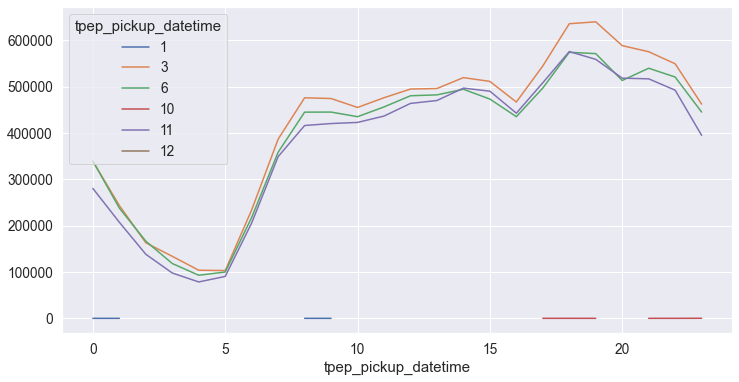

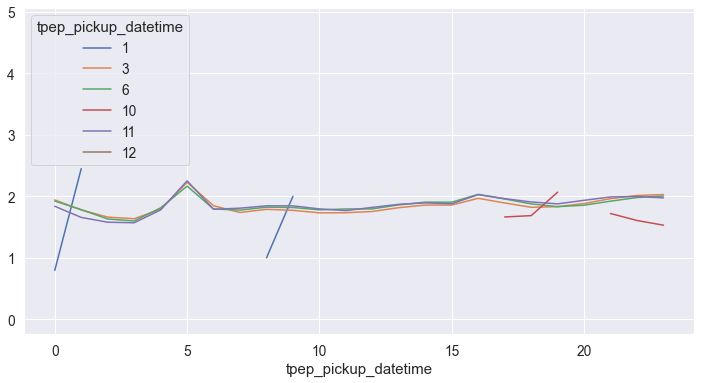

In [22]:
taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['tpep_pickup_datetime'].dt.month])['tip_amount'].count().unstack().plot(figsize=(12, 6))

taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['tpep_pickup_datetime'].dt.month])['tip_amount'].mean().unstack().plot(figsize=(12, 6))

Most of trips are recorded in the afternoon, however, tips are more expensive at night. Let's introduce a new variable according to time
Month distributions look similar which indicate that there are not seasonal scenarios to evaluate
Let's see what happen in different weekdays... 

<AxesSubplot:xlabel='tpep_pickup_datetime'>

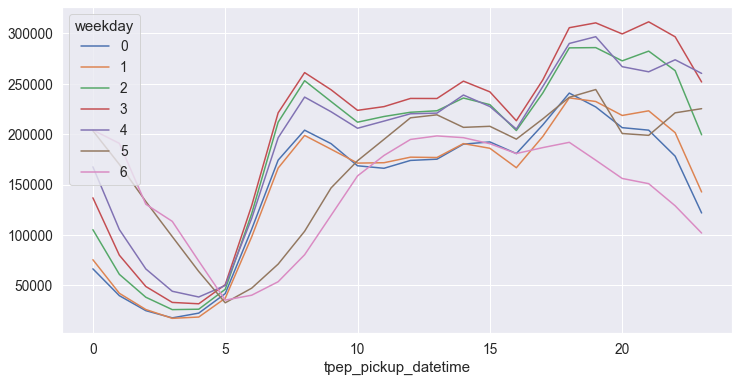

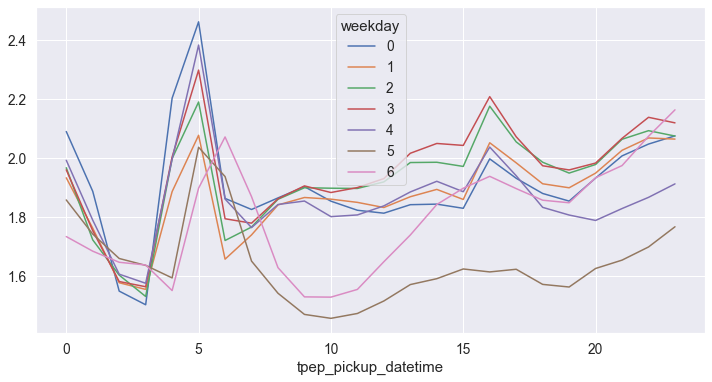

In [23]:
taxi_trips_2017['weekday'] = taxi_trips_2017['tpep_pickup_datetime'].dt.dayofweek

taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['weekday']])['tip_amount'].count().unstack().plot(figsize=(12, 6))

taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['weekday']])['tip_amount'].mean().unstack().plot(figsize=(12, 6))

Mmm interesting... As we can expect, tips are higher at night and workdays, but let's check stationarity

C:\Users\berta\anaconda3\envs\taxi_nyc\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


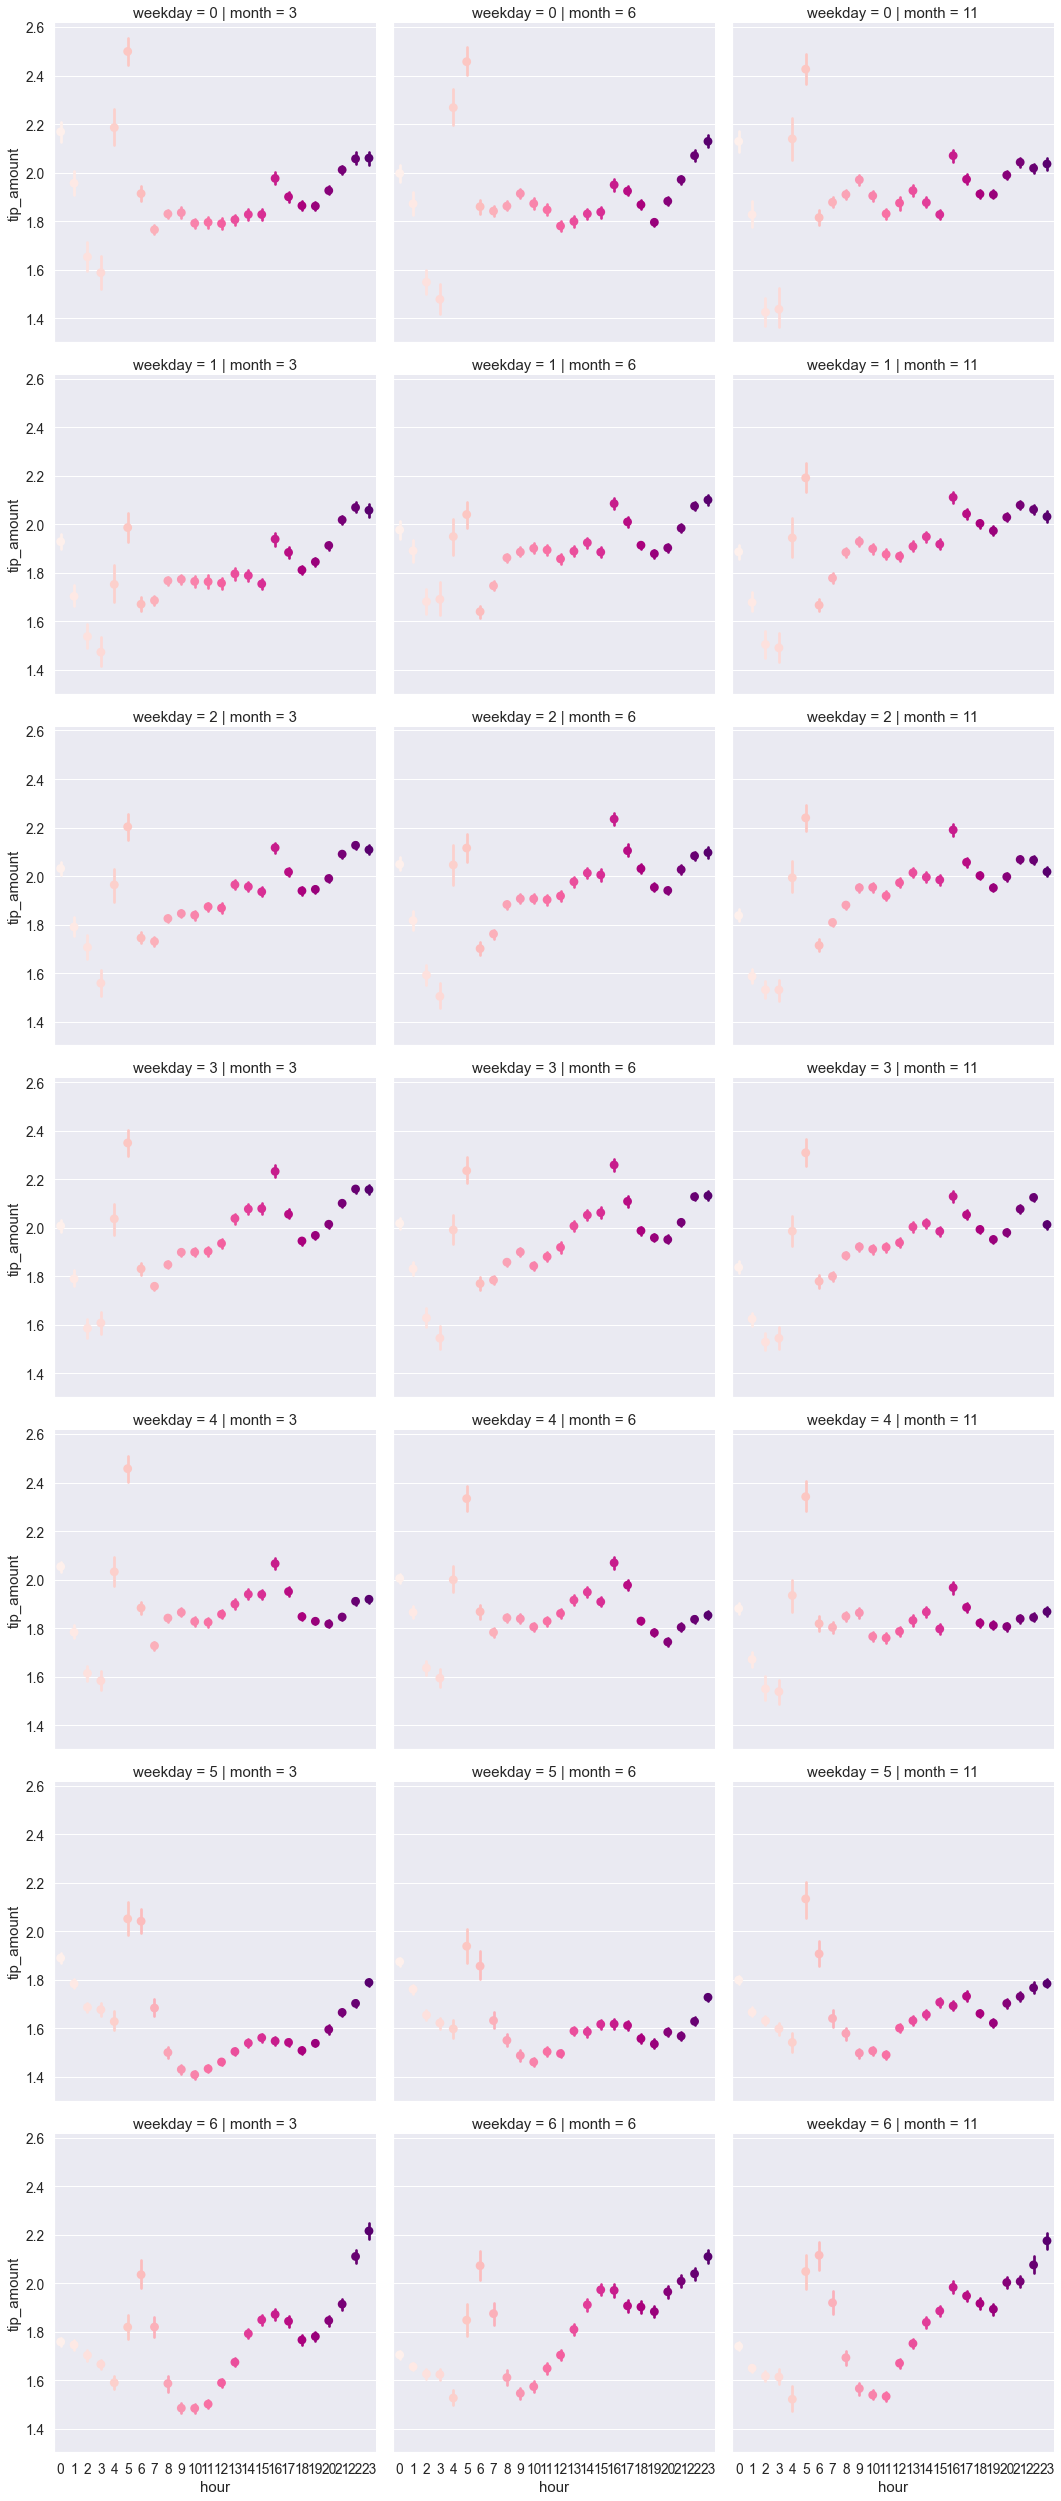

In [31]:
taxi_trips_2017['hour'] = taxi_trips_2017['tpep_pickup_datetime'].dt.hour
taxi_trips_2017['month_pickup'] = taxi_trips_2017['tpep_pickup_datetime'].dt.month
taxi_trips_2017['month_dropoff'] = taxi_trips_2017['tpep_dropoff_datetime'].dt.month
taxi_trips_2017 = taxi_trips_2017[taxi_trips_2017["month_pickup"].isin([3, 6, 11])]
taxi_trips_2017 = taxi_trips_2017[taxi_trips_2017["month_dropoff"].isin([3, 6, 11])]
sns.factorplot(data = taxi_trips_2017, x = "hour", y = "tip_amount",
              col = "month", row = "weekday", palette = 'RdPu')

As it can be seen, there is defined hour distribution among weekdays but different months seems to be similar